# Assortativity of SA network

In this section we will look at different assortativities found within the SeekingAlpha network. Firstly, degree assortativities will be focused on. After this, attribute assortativities will be looked at to discover which attributes affect, how companies tend to be discussed together.

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

Reading SeekingAlpha network:

In [2]:
G = nx.read_gexf('SA.gexf')

First we can look at the degree assortativity of the network alongside the degree assortativity coefficient.

C:\Users\lassi\AppData\Local\Temp/ipykernel_292/434456813.py:5: RuntimeWarning: invalid value encountered in true_divide
  P_kk = e_ij/e_ij.sum(axis=1)
C:\Users\lassi\AppData\Local\Temp/ipykernel_292/434456813.py:8: RuntimeWarning: invalid value encountered in true_divide
  P_kk_rand = q_k.T.dot(q_k)/ q_k


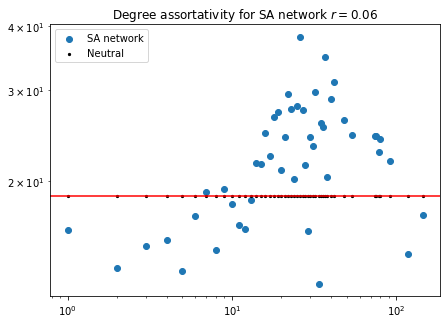

In [3]:
degrees = [degree for _, degree in G.degree()]
k_max = max(degrees)
e_ij = nx.degree_mixing_matrix(G, mapping={x: x for x in range(k_max +1)}, normalized=True)
k = np.arange(k_max+1)
P_kk = e_ij/e_ij.sum(axis=1)
k_nn = k.dot(P_kk)
q_k = e_ij.sum(axis=1).reshape(1, -1)
P_kk_rand = q_k.T.dot(q_k)/ q_k
k_nn_rand = k.dot(P_kk_rand)
k_nn_rand_exp = sum([degree**2 for degree in degrees]) / sum(degrees)

r = nx.degree_assortativity_coefficient(G)
plt.figure(figsize=(7,5))
plt.scatter(k, k_nn, label='SA network')
plt.axhline(k_nn_rand_exp, c='r')
plt.scatter(k, k_nn_rand, c='k', s=5, label='Neutral')
plt.loglog()
plt.legend(loc='upper left')
plt.title(fr'Degree assortativity for SA network $r={r:.2f}$')
plt.show()

The results seem to indicate a positive correlation in the degree assortativity coefficient, which means that frequently discussed companies tend to be discussed alongside other highly discussed companies. This is sensible, as popular companies tend to be most often compared to other big ticket companies.

Now after seeing this another question arises quickly. Are there some attribute assortativities that exist within the network? Initial thought is that companies from the same sector are likely discussed with each other.

In [4]:
r_sector = nx.attribute_assortativity_coefficient(G, "sector")
r_ebitda = nx.numeric_assortativity_coefficient(G, "ebitda")
r_mcap = nx.numeric_assortativity_coefficient(G, "market_cap")
print(f"""
Sector correlation: {r_sector:.3}
Ebitda correlation: {r_ebitda:.3}
Market cap correlation: {r_mcap:.3}
""")


Sector correlation: 0.603
Ebitda correlation: 7.5e-07
Market cap correlation: 4.5e-06



Now it seems like sector is the only attribute that has a clear correlation, so we can visualize that to further investigate what information could be extracted from that.

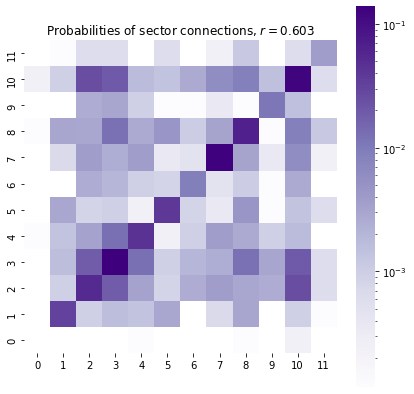

In [5]:
unique_sectors = np.unique(list(dict(G.nodes(data='sector')).values()))
sector_to_num = {
    sector: i for i, sector in enumerate(unique_sectors)
}
sector_mix_mat = nx.attribute_mixing_matrix(G, 'sector', mapping=sector_to_num)
plt.figure(figsize=(7,7))
sns.heatmap(sector_mix_mat, square=True, cmap='Purples', norm=mcolors.LogNorm())
plt.gca().invert_yaxis()
plt.gca().set_title(fr'Probabilities of sector connections, $r={r_sector:.3f}$')
plt.show()

Now when visualized the high sector assortativity is clear also when by simply looking at the mixing matrix. From this we can also see that the highest assortativity is with 3, 7, and 10 sector values. These can be checked using the sector_to_num dictionary:

In [6]:
for sector_name, sector_id in sector_to_num.items():
    print(f'{sector_name}: {sector_id}')

: 0
Basic Materials: 1
Communication Services: 2
Consumer Cyclical: 3
Consumer Defensive: 4
Energy: 5
Financial Services: 6
Healthcare: 7
Industrials: 8
Real Estate: 9
Technology: 10
Utilities: 11


Now interestingly the highest assortativity is found with Consumer Cyclical, Healthcare, and Technology sectors. These are also the most represented sectors within the communities found within the notebook discussing community discovery. Especially technology and healthcare sectors are predominantly represented within the two largest Louvain communities. Also the high assortativity that is seen between the technology and communication services is something that is present, as it is in the largest Louvain group found in the community discovery section.

One further question that could be interesting is to see whether posting profit/loss is a factor that correlation between connections. So are e.g., net-loss speculative investment mostly discussed with each other, or is there perhaps even a negative correlation?

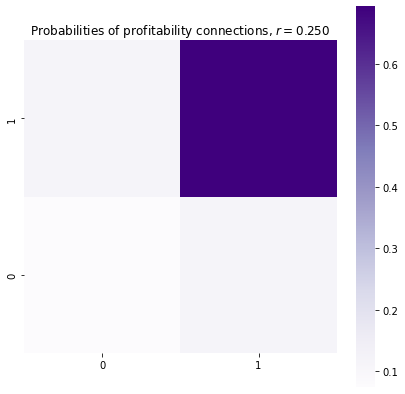

In [7]:
profitable = {
    node: ebitda > 0 for node, ebitda in G.nodes(data='ebitda')
}
nx.set_node_attributes(G, profitable, 'profitable')
profitable_map = {True: 1, False: 0}
r_profitable = nx.numeric_assortativity_coefficient(G, 'profitable')
sector_mix_mat = nx.attribute_mixing_matrix(G, 'profitable', mapping=profitable_map)
plt.figure(figsize=(7,7))
sns.heatmap(sector_mix_mat, square=True, cmap='Purples')
plt.gca().invert_yaxis()
plt.gca().set_title(fr'Probabilities of profitability connections, $r={r_profitable:.3f}$')
plt.show()

While the visual does not show much in terms of assortativity, the correlation coefficient is rather high suggesting there is one. The reason for this is the imbalance in the profitable/loss-making companies in the data. The actual differences between randomly formed connections and the realised connections can be shown as follows:

In [8]:
amt_profitable = len([_ for is_profitable in profitable.values() if is_profitable])
amt_loss = len(profitable) - amt_profitable
print(f"""
Profitable-to-profitable connection random vs. realised: {(amt_profitable / len(profitable))**2:.2} vs. {sector_mix_mat[1,1]:.2}
Loss-to-loss connection random vs. realised: {(amt_loss / len(profitable))**2:.2} vs. {sector_mix_mat[0,0]:.2}
""")


Profitable-to-profitable connection random vs. realised: 0.57 vs. 0.69
Loss-to-loss connection random vs. realised: 0.061 vs. 0.075



Thus it does seem quite clear that there is also a clear attribute assortativity with this as well in the network. This could be due to safer investments generally being contrasted to other safe investments, while more speculative investments can be often contrasted to other similar investments. This can also be due to the beforehand visualized sector assortativity, as some sectors contain more loss-making companies, while some mostly consist of profitable companies. Example of this is the technology/healthcare fields, which are full of speculative loss leaders.